# Batch Norm
$$ \mathbf{BN}(x) = \gamma \odot \frac {x - \mu} { \sigma } + \beta $$

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [ ]:
# 复习一下：randint & .mean(dim=tuple | int)
x = torch.randint(0, 100, (3, 3), dtype=float)
x, x.mean(), x.mean(dim=0), x.mean(dim=1)

(tensor([[21., 13., 12.],
         [94., 28., 57.],
         [17., 70., 42.]], dtype=torch.float64),
 tensor(39.3333, dtype=torch.float64),
 tensor([44., 37., 37.], dtype=torch.float64),
 tensor([15.3333, 59.6667, 43.0000], dtype=torch.float64))

In [ ]:
def batch_norm(x, gamma, beta, moving_avg, moving_var, eps, momentum):
    if not torch.is_grad_enabled():  # 检测为推理或训练
        y = gamma * ((x - moving_avg) / torch.sqrt(moving_var + eps)) + beta
    
    else:
        assert len(x.shape) in (2, 4)

        if len(x.shape) == 2:
            avg = x.mean(dim=0)
            var = ((x - avg) ** 2).mean(dim=0)

        if len(x.shape) == 4:
            avg = x.mean(dim=(0, 2, 3), keepdim=True) # 维度保持，(1, b, 1, 1)
            var = ((x - avg) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        y = gamma * ((x - avg) / torch.sqrt(var + eps)) + beta
        # moving_avg = moving_avg * momentum + avg * (1 - momentum)  
        # moving_var = moving_var * momentum + var * (1 - momentum)
        moving_avg.mul_(momentum).add_((1-momentum)*avg)
        moving_var.mul_(momentum).add_((1-momentum)*var)

    # return y, moving_avg.data, moving_var.data
    return y

In [ ]:
class Batch_Norm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1) #大概是为了方便广播
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape)) 
        # self.moving_avg = torch.zeros(shape)
        # self.moving_var = torch.ones(shape)
        self.register_buffer('moving_avg', torch.zeros(shape)) # self.register_buffer(name, tensor) 注册不可训练参数
        self.register_buffer('moving_var', torch.ones(shape))

    def forward(self, x):
        y = batch_norm(
            x, self.gamma, self.beta, self.moving_avg, self.moving_var, 1e-5, 0.9)
        return y
                                             


In [21]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.Sigmoid(), Batch_Norm(6, 4),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(), Batch_Norm(16, 4),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Flatten(),
    nn.Linear(16 * 4 * 4, 120), Batch_Norm(120, 2), nn.Sigmoid(),
    nn.Linear(120, 84), Batch_Norm(84, 2), nn.Sigmoid(),
    nn.Linear(84, 10)
)

loss 0.257, train acc 0.904, test acc 0.840
34278.9 examples/sec on cuda:0


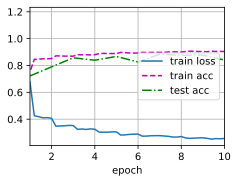

In [22]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

---
## PyTorch中的BatchNorm

```
nn.BatchNorm1d(num_features)
nn.BatchNorm2d(num_features)
```
*更快*

In [23]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.Sigmoid(), nn.BatchNorm2d(6),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(), nn.BatchNorm2d(16),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
    nn.Flatten(),
    nn.Linear(16 * 4 * 4, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

loss 0.253, train acc 0.905, test acc 0.861
55282.0 examples/sec on cuda:0


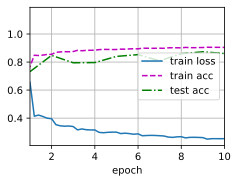

In [24]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())